In [53]:
import torch.nn as nn
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

[DCGAN Code Source](https://debuggercafe.com/dcgan-pytorch/)

In [42]:
# generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [44]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [46]:
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

In [48]:
def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

In [54]:
def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

In [55]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [56]:
# learning parameters / configurations according to paper
image_size = 64 # we need to resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train

In [58]:
# image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

# prepare the data
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [59]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 

In [61]:
# initialize generator weights
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [60]:
# initialize discriminator weights
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [62]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# loss function
criterion = nn.BCELoss()

In [85]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size).view(-1)
    # get the fake label vector
    fake_label = label_fake(b_size).view(-1)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1)
    loss_real = criterion(output_real, real_label)
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake).view(-1)
    loss_fake = criterion(output_fake, fake_label)
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

In [90]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size).view(-1)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake).view(-1)
    loss = criterion(output, real_label)
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

In [91]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [92]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [94]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

391it [01:21,  4.80it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.55it/s]

Epoch 1 of 25
Generator loss: 5.09278536, Discriminator loss: 0.51866537


391it [01:21,  4.77it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.52it/s]

Epoch 2 of 25
Generator loss: 3.61858130, Discriminator loss: 0.63183773


391it [01:22,  4.76it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.49it/s]

Epoch 3 of 25
Generator loss: 3.54395461, Discriminator loss: 0.65376455


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.46it/s]

Epoch 4 of 25
Generator loss: 3.19677973, Discriminator loss: 0.70859289


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:08,  5.65it/s]

Epoch 5 of 25
Generator loss: 2.89019179, Discriminator loss: 0.74639940


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.52it/s]

Epoch 6 of 25
Generator loss: 3.08736467, Discriminator loss: 0.77687550


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.55it/s]

Epoch 7 of 25
Generator loss: 3.36090541, Discriminator loss: 0.66462058


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:12,  5.38it/s]

Epoch 8 of 25
Generator loss: 3.18778014, Discriminator loss: 0.71602482


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.55it/s]

Epoch 9 of 25
Generator loss: 3.38874626, Discriminator loss: 0.62749571


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.46it/s]

Epoch 10 of 25
Generator loss: 3.17513180, Discriminator loss: 0.66224372


391it [01:22,  4.75it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.49it/s]

Epoch 11 of 25
Generator loss: 3.86841750, Discriminator loss: 0.45021152


391it [01:22,  4.75it/s]                                                                                               
  0%|                                                                                          | 0/390 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000237536DC160>
Traceback (most recent call last):
  File "C:\Users\eliot\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\eliot\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
  0%|▏                                                                                 | 1/390 [00:00<01:15,  5.18it/s]

Epoch 12 of 25
Generator loss: 4.27039576, Discriminator loss: 0.51702398


391it [01:22,  4.72it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:09,  5.62it/s]

Epoch 13 of 25
Generator loss: 2.43097019, Discriminator loss: 0.85016352


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.43it/s]

Epoch 14 of 25
Generator loss: 3.02983809, Discriminator loss: 0.60665971


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.49it/s]

Epoch 15 of 25
Generator loss: 3.47736764, Discriminator loss: 0.49707797


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.46it/s]

Epoch 16 of 25
Generator loss: 4.43416548, Discriminator loss: 0.49226663


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.43it/s]

Epoch 17 of 25
Generator loss: 3.16855907, Discriminator loss: 0.66493511


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.40it/s]

Epoch 18 of 25
Generator loss: 3.68381572, Discriminator loss: 0.55576152


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:11,  5.43it/s]

Epoch 19 of 25
Generator loss: 2.71678829, Discriminator loss: 0.71610463


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.49it/s]

Epoch 20 of 25
Generator loss: 2.84788918, Discriminator loss: 0.71596605


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.49it/s]

Epoch 21 of 25
Generator loss: 3.42394519, Discriminator loss: 0.60076219


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:10,  5.52it/s]

Epoch 22 of 25
Generator loss: 3.09965873, Discriminator loss: 0.59715986


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:09,  5.59it/s]

Epoch 23 of 25
Generator loss: 6.41938734, Discriminator loss: 0.01769442


391it [01:22,  4.73it/s]                                                                                               
  0%|▏                                                                                 | 1/390 [00:00<01:12,  5.35it/s]

Epoch 24 of 25
Generator loss: 7.63360405, Discriminator loss: 0.00384031


391it [01:22,  4.72it/s]                                                                                               


Epoch 25 of 25
Generator loss: 9.34149742, Discriminator loss: 0.03800935


In [95]:
# save the model weights to disk
torch.save(generator.state_dict(), 'generator1.pth')

In [113]:
losses_g = [loss.cpu().detach().numpy() for loss in losses_g]
losses_d = [loss.cpu().detach().numpy() for loss in losses_d]

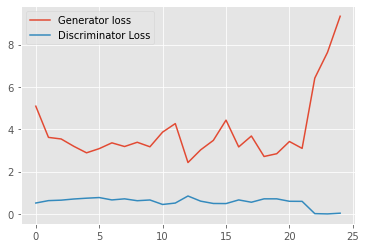

In [114]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [115]:
def imshow(img):
    """
    Display a PyTorch tensor as an image using matplotlib
    """
    # unnormalize the image 
    img = img / 2 + 0.5
    npimg = img.numpy()
    
    # transpose numpy array from CxHxW to HxWxC format and display image 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [122]:
img = generator(noise).detach().cpu()
images = img[:4]

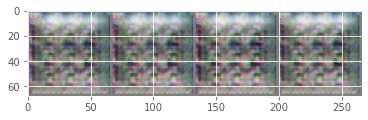

In [123]:
# display the batch
imshow(torchvision.utils.make_grid(images))